# Gene-Cell Cluster Dotplot Analysis

This notebook:
1. Loads clustering results from the gene-cell clustering pipeline.
2. Renames clusters using a custom mapping.
3. Applies `sc.tl.rank_genes_groups` to derive top genes for each cluster.
4. Draws a dotplot to visualize the attention of top-ranked genes across clusters.


In [1]:
import pickle
from pathlib import Path
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# Set paths
results_path = Path('intermediate_data/clustering_results_tx-bd_layer_4.pkl')

# Load clustering results
with open(results_path, 'rb') as f:
    data = pickle.load(f)

results = data['results']
attention_matrix = data['attention_matrix']
gene_names = data['gene_names']
cell_ids = data['cell_ids']

# Get clustering labels (first parameter combination)
first_key = list(results.keys())[0]
#gene_labels = results[first_key]['gene_clustering']['cluster_labels']
cell_labels = results[first_key]['cell_clustering']['cluster_labels']

print(f'Loaded matrix shape: {attention_matrix.shape}')
#print(f'Number of genes: {len(gene_names)}')
print(f'Number of cells: {len(cell_ids)}')


Loaded matrix shape: (538, 10000)
Number of cells: 10000


In [2]:
print(gene_names)

['RHOA', 'PFDN5', 'CAPN8', 'HNRNPA2B1', 'ASAH1', 'PTPRC', 'ATP5MD', 'ATP5F1B', 'NOP53', 'AMY2A', 'GNAS', 'GPR183', 'NegControlProbe_00034', 'PABPC1', 'SLC25A3', 'HSP90B1', 'LILRA4', 'FSTL1', 'SUMO2', 'CD34', 'AQP3', 'TMBIM6', 'MS4A4A', 'CFAP53', 'CIB1', 'DUSP1', 'IL1B', 'OST4', 'TM4SF4', 'STEAP4', 'ACTG2', 'SFTA2', 'DSP', 'SLC26A2', 'NDUFC2', 'EPCAM', 'PMP22', 'CFB', 'CD28', 'CAP1', 'EDN1', 'FKBP11', 'VAMP8', 'DES', 'SST', 'SERPINB1', 'EIF2S2', 'SSR3', 'OGN', 'CXCR4', 'GEM', 'MEDAG', 'PPA1', 'FGL2', 'CLEC14A', 'RTN4', 'UPK3B', 'CD3E', 'TFPI', 'APCDD1', 'PCSK2', 'MZB1', 'YAF2', 'TCIM', 'HINT1', 'BCL2L11', 'NUPR1', 'SKP1', 'SCGB2A1', 'OSTC', 'MFAP5', 'SFRP2', 'KNG1', 'CD3D', 'DLK1', 'SSR2', 'FSTL3', 'EPAS1', 'BIRC3', 'FBN1', 'MYH9', 'GLIPR1', 'KLF6', 'BASP1', 'UGP2', 'ADGRL4', 'FBLN1', 'C7', 'CD4', 'ALDH1A3', 'LYVE1', 'VWF', 'DMBT1', 'MRC1', 'SSR4', 'LTBP2', 'CYP2F1', 'MYLK', 'PDGFRA', 'BTF3', 'SERPINB3', 'C1R', 'NNMT', 'LAPTM5', 'MMRN2', 'MS4A6A', 'PPP1R12B', 'PRDM1', 'HMGCS2', 'HSPA8',

## 1. Rename Cluster Labels
Define a mapping from cluster numbers to new names.

In [3]:
# Define new cluster names (example mapping)
new_cluster_names = {
    0: 'Fibroblast-Immune-Endocrine Mixed',
    1: 'Tumor Dominant',
    2: 'Immune-Fibroblast Mixed',
    3: 'Macrophage-Mixed',
    4: 'Acinar-Metaplastic',
    5: 'Endocrine Dominant',
    6: 'Endothelial Dominant',
    7: 'Acinar-Tumor Mixed'
}

# Map integer cluster labels to new names (if label not in mapping, keep as str(label))
cell_labels_named = [new_cluster_names.get(lbl, str(lbl)) for lbl in cell_labels]

# Show unique cluster names
print('Cell clusters:', set(cell_labels_named))


Cell clusters: {'Tumor Dominant', 'Immune-Fibroblast Mixed', 'Acinar-Tumor Mixed', 'Fibroblast-Immune-Endocrine Mixed', 'Endocrine Dominant', 'Acinar-Metaplastic', 'Macrophage-Mixed', 'Endothelial Dominant'}


## 2. Create AnnData and Run `rank_genes_groups`
We treat the attention matrix as gene × cell, and cluster genes.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


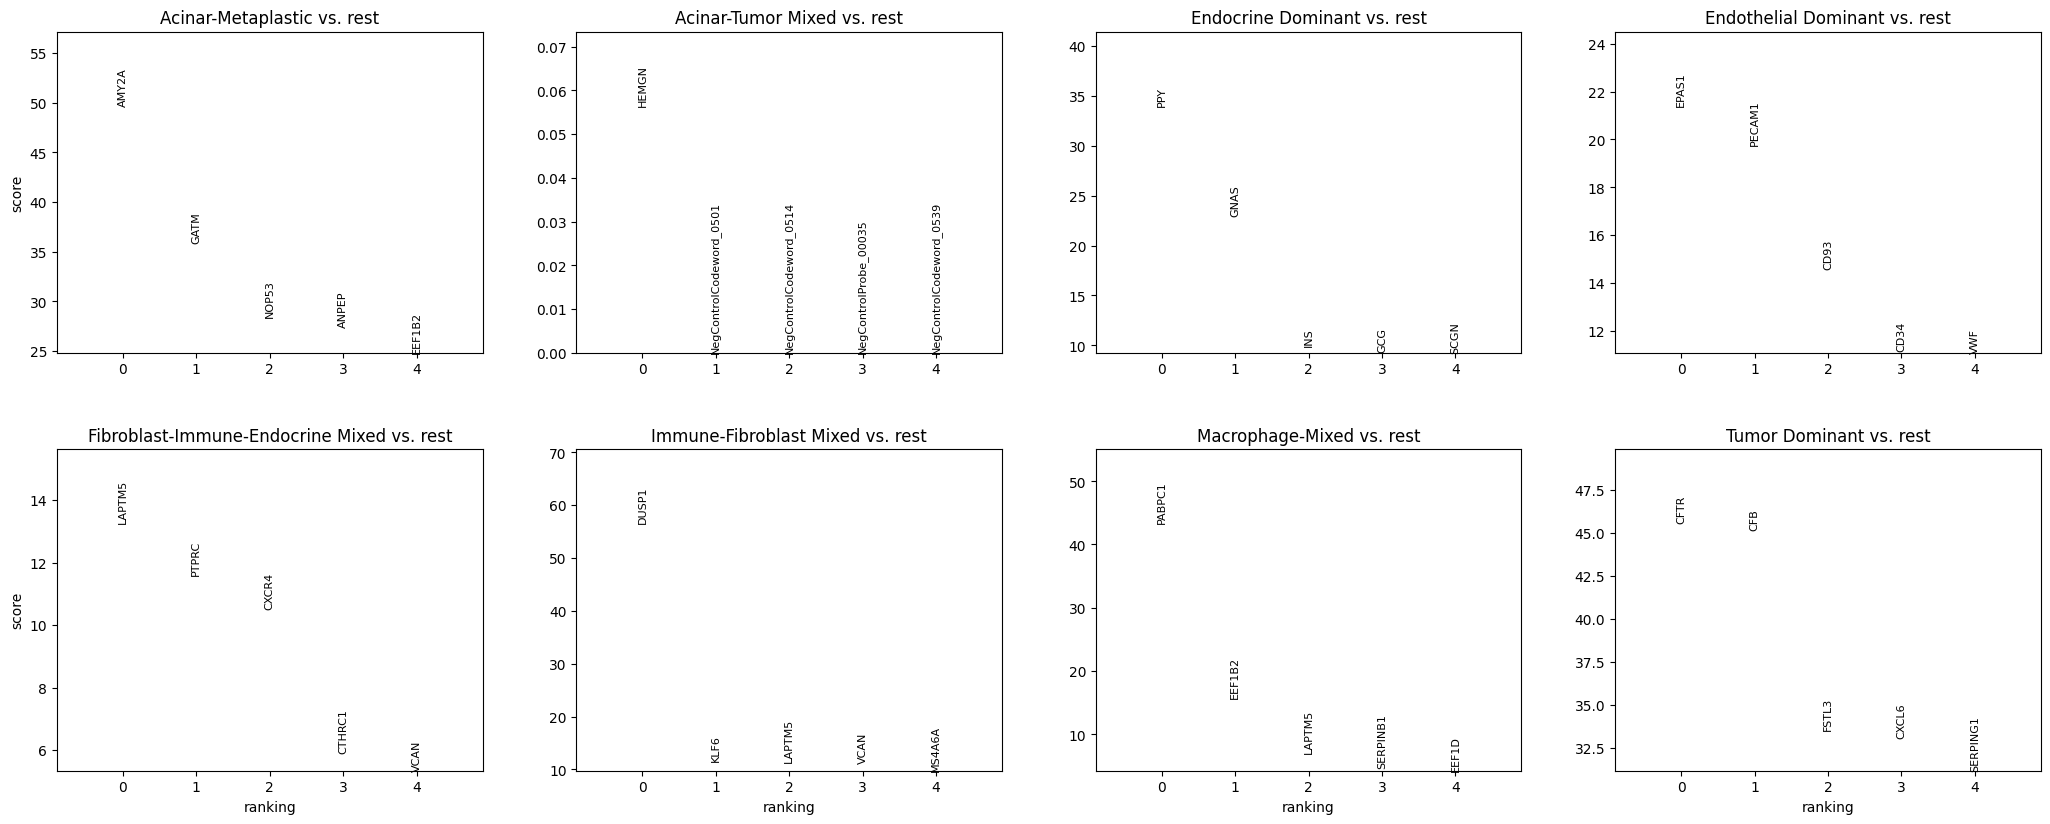

In [4]:
# Create AnnData object for genes
adata = sc.AnnData(attention_matrix.T)
adata.obs['cluster'] = pd.Categorical(cell_labels_named)
adata.obs['cell_id'] = cell_ids
adata.var_names = gene_names

# Run rank_genes_groups to find top genes for each cluster
sc.tl.rank_genes_groups(adata, groupby='cluster', method='wilcoxon', n_genes=10)
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False, show=True)


## 3. Dotplot of Top Genes Across Clusters
Visualize the attention of top-ranked genes across clusters.

Cluster Acinar-Metaplastic has top genes: ['AMY2A' 'GATM' 'NOP53' 'ANPEP' 'EEF1B2']
Cluster Acinar-Tumor Mixed has top genes: ['HEMGN']
Cluster Endocrine Dominant has top genes: ['PPY' 'GNAS' 'INS' 'GCG' 'SCGN']
Cluster Endothelial Dominant has top genes: ['EPAS1' 'PECAM1' 'CD93' 'CD34' 'VWF']
Cluster Fibroblast-Immune-Endocrine Mixed has top genes: ['LAPTM5' 'PTPRC' 'CXCR4' 'CTHRC1' 'VCAN']
Cluster Immune-Fibroblast Mixed has top genes: ['DUSP1' 'KLF6' 'LAPTM5' 'VCAN' 'MS4A6A']
Cluster Macrophage-Mixed has top genes: ['PABPC1' 'EEF1B2' 'LAPTM5' 'SERPINB1' 'EEF1D']
Cluster Tumor Dominant has top genes: ['CFTR' 'CFB' 'FSTL3' 'CXCL6' 'SERPING1']
categories: Acinar-Metaplastic, Acinar-Tumor Mixed, Endocrine Dominant, etc.
var_group_labels: Tumor Cells, Fibroblasts, Acinar Metaplastic Cells, etc.


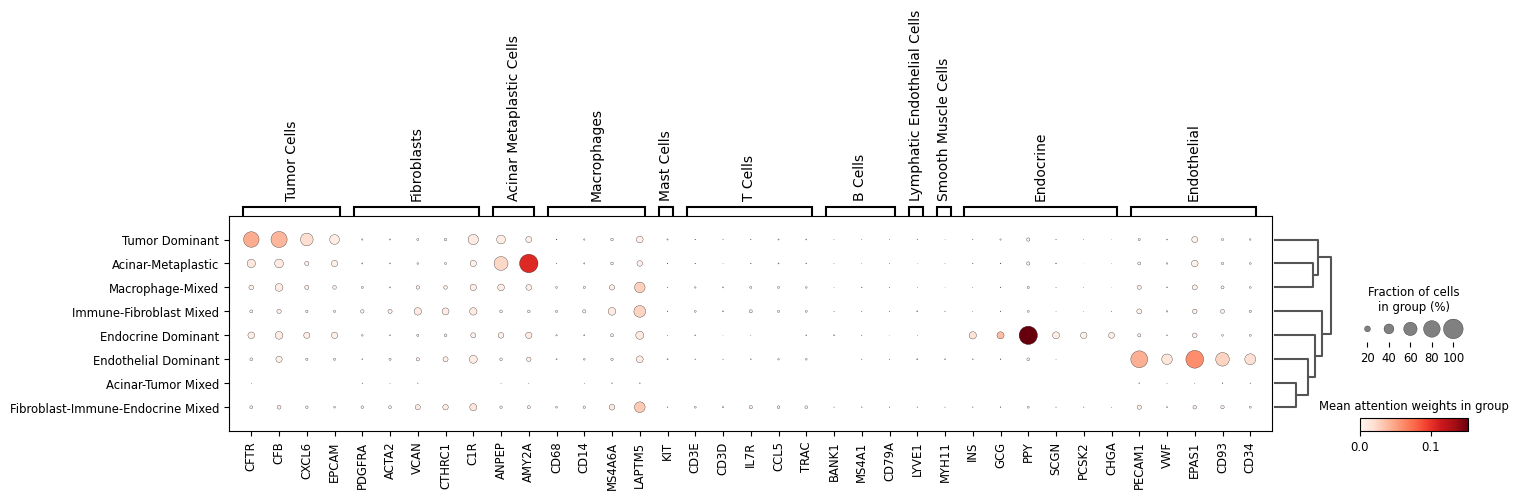

In [7]:
top_genes = set()
rank_res = adata.uns['rank_genes_groups']
groups = rank_res['names'].dtype.names

marker_genes_dict = {
    "Tumor Cells": ["CFTR", "CFB", "CXCL6", "EPCAM"],
    "Fibroblasts": ["PDGFRA", "ACTA2", "VCAN", "CTHRC1", "C1R"],
    "Acinar Metaplastic Cells": ["ANPEP", "AMY2A"],
    "Macrophages": ["CD68", "CD14", "MS4A6A", "LAPTM5"],
    "Mast Cells": ["KIT"],
    "T Cells": ["CD3E", "CD3D", "IL7R", "CCL5", "TRAC"],
    "B Cells": ["BANK1", "MS4A1", "CD79A"],
    "Lymphatic Endothelial Cells": ["LYVE1"],
    "Smooth Muscle Cells": ["MYH11"],
    "Endocrine": ["INS", "GCG", "PPY", "SCGN", "PCSK2", "CHGA"],
    "Endothelial": ["PECAM1", "VWF", "EPAS1", "CD93", "CD34"]
}

for group in groups:
    names = rank_res['names'][group][:5]
    lfc = rank_res['logfoldchanges'][group]
    # Select genes with LFC above threshold
    for gene, lfc_val in zip(names, lfc):
        if lfc_val < 0.05:
            names = names[names != gene]
    print(f"Cluster {group} has top genes: {names}")
    top_genes.update(names)

top_genes = list(top_genes)

# Dotplot
sc.pl.dotplot(
    adata,
    marker_genes_dict,
    groupby='cluster',
    dendrogram=True,
    show=True,
    colorbar_title='Mean attention weights in group'
)

## 4. Re-create AnnData and run dotplots

In [9]:
from scripts.gene_cell_clustering_comparison_processing import load_annotated_cell_types, align_cell_ids

adata_true = sc.AnnData(attention_matrix.T)

# Load annotated cell types
cell_types_dict, _, _ = load_annotated_cell_types()

# Modify the cell_types_dict values as requested
for k, v in cell_types_dict.items():
    if v in ["Endocrine 1", "Endocrine 2"]:
        cell_types_dict[k] = "Endocrine"
    elif v in ["Tumor Cells", "CFTR- Tumor Cells"]:
        cell_types_dict[k] = "Tumor Cells"

# Align cell IDs
filtered_true_labels = []
for cell_id in cell_ids:
  filtered_true_labels.append(cell_types_dict[cell_id])
  
print(set(filtered_true_labels))

{'Endothelial', 'Smooth Muscle Cells', 'B Cells', 'Tumor Cells', 'Mast Cells', 'T Cells', 'Macrophages', 'Endocrine', 'CXCL9/10 Cells', 'Acinar', 'Ductal', 'Metaplastic Cells', 'Fibroblasts', 'Lymphatic Endothelial Cells'}


In [47]:
pd.Categorical(filtered_true_labels)

# count each cell type in the true labels
true_labels_count = pd.Series(filtered_true_labels).value_counts()
print(true_labels_count)

Tumor Cells                    2094
Macrophages                    1560
Fibroblasts                    1521
Metaplastic Cells              1064
Acinar                          914
Endocrine                       868
T Cells                         693
Endothelial                     550
CXCL9/10 Cells                  165
Mast Cells                      165
B Cells                         136
Ductal                          111
Lymphatic Endothelial Cells      80
Smooth Muscle Cells              79
Name: count, dtype: int64


In [43]:
def invert_dendrogram(adata, groupby):
    import numpy as np
    key = f'dendrogram_{groupby}'
    dendrogram = adata.uns[key]
    
    # Reverse the ordered categories and indices to flip the y-axis
    dendrogram['categories_ordered'] = dendrogram['categories_ordered'][::-1]
    dendrogram['categories_idx_ordered'] = dendrogram['categories_idx_ordered'][::-1]
    
    # Also update dendrogram_info for leaf order and labels
    dendro_info = dendrogram['dendrogram_info']
    dendro_info['leaves'] = dendro_info['leaves'][::-1]
    if 'ivl' in dendro_info:
        dendro_info['ivl'] = dendro_info['ivl'][::-1]
    
    # Mirror the icoord (y-coordinates for orientation='left') over the vertical midpoint for proper dendrogram flip
    tmp = np.asarray(dendro_info['icoord'])
    midpoint = (np.max(tmp) + np.min(tmp)) / 2
    dendro_info['icoord'] = 2 * midpoint - tmp
    
    # Update the stored dendrogram
    adata.uns[key] = dendrogram

In [44]:
adata_true.obs['cluster'] = pd.Categorical(filtered_true_labels)
adata_true.obs['cell_id'] = cell_ids
adata_true.var_names = gene_names

# Plot dendrogram
sc.tl.dendrogram(adata_true, groupby='cluster')

categories: Acinar, B Cells, CXCL9/10 Cells, etc.
var_group_labels: Tumor Cells, Fibroblasts, Acinar Metaplastic Cells, etc.


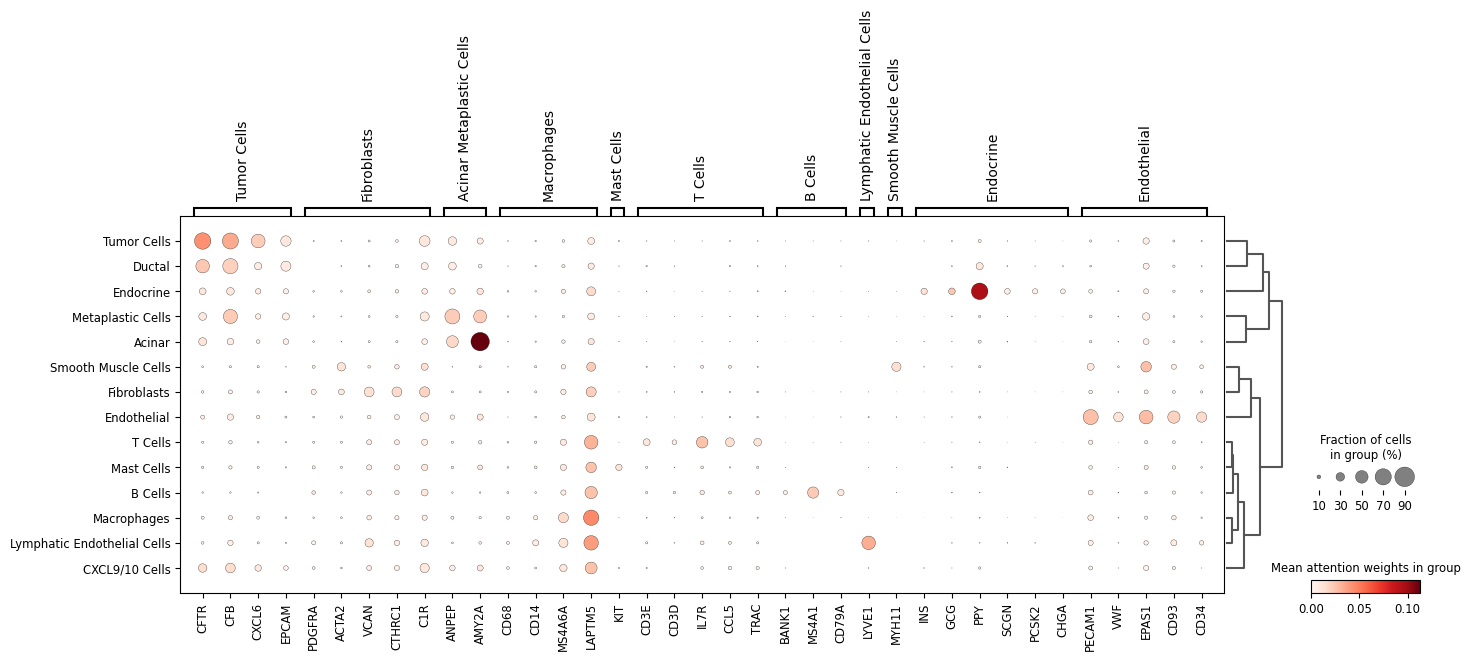

In [45]:
# invert dendrogram
invert_dendrogram(adata_true, 'cluster')

sc.pl.dotplot(adata_true, marker_genes_dict, groupby='cluster', dendrogram=True, show=True, colorbar_title='Mean attention weights in group')

In [46]:
adata_true.uns['dendrogram_cluster']['categories_ordered']

['Tumor Cells',
 'Ductal',
 'Endocrine',
 'Metaplastic Cells',
 'Acinar',
 'Smooth Muscle Cells',
 'Fibroblasts',
 'Endothelial',
 'T Cells',
 'Mast Cells',
 'B Cells',
 'Macrophages',
 'Lymphatic Endothelial Cells',
 'CXCL9/10 Cells']